Housekeeping

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

Auxiliary functions

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def read_descriptive_stats(filename,keyword_data,keyword_col,ncols,rownames,start=2,debug=False):
    t0 = start
    t1 = ncols+start
    table_raw = np.empty(t1-t0)
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword_data:
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)))
        elif len(words)>1 and words[0] == keyword_col:
            colnames = words[t0:t1]

    return pd.DataFrame(table_raw[1:,:], columns=colnames, index=rownames)
 
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table   

Date dictionaries

In [3]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

time_periods_thin = []
for y in range(2006,2023):
    time_periods_thin.append(str(y))

<a id='index'></a>


# Quantile regressions for tenure: coefficients by year

### Women, 30-40

Jump to
 - [Men 30-40](#urgh_3035)
 
 
  - [Employment regresssions](#employment)
 

 --------------
 Split result tables
 --------------
 Split result tables

In [6]:
path = './results/'
name = 'sqtreg_mothers_3040_hemp_yy_agefix'

file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)
tab_moms_45_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)
tab_moms_45_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)


file_split('{}_0k.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'{}_0k_1.log'.format(name),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)
tab_moms_45_50_0k = read_table(path+'{}_0k_2.log'.format(name),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)
tab_moms_45_75_0k = read_table(path+'{}_0k_3.log'.format(name),
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)

In [7]:
coeffs_period = {}
lower_95_period = {}
upper_95_period = {}

all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs[q]['upper_95q{}'.format(q)][period]))
    coeffs_period[q] = coeffs.copy()
    lower_95_period[q] = lower.copy()
    upper_95_period[q] = upper.copy()


In [8]:
coeffs_period_0k = {}
lower_95_period_0k = {}
upper_95_period_0k = {}
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_0k[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_0k[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_0k[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_0k[q] = coeffs.copy()
    lower_95_period_0k[q] = lower.copy()
    upper_95_period_0k[q] = upper.copy()


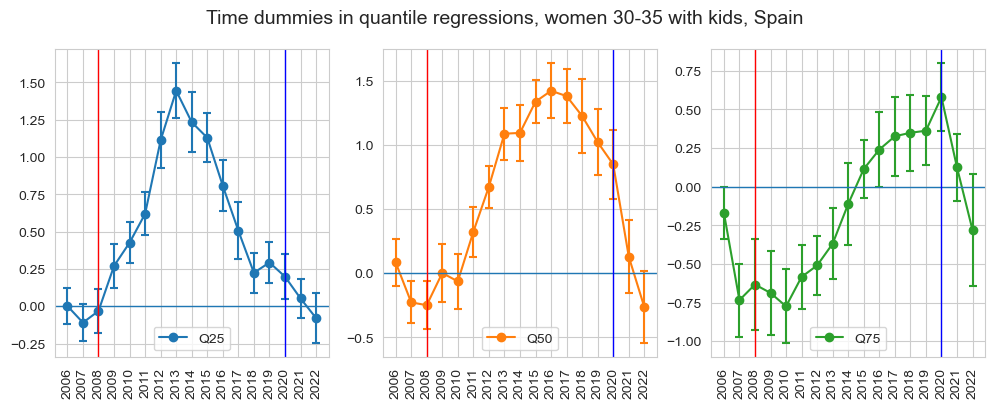

In [9]:
T = len(time_periods_thin)
time_periods_thin_labels= time_periods_thin
time_dict = dict(zip(time_periods_thin, np.arange(0,T*2,2)))
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.suptitle('Time dummies in quantile regressions, women 30-35 with kids, Spain',fontsize=14)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='Q{}'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(time_dict["2008"],c='r',lw=1)
    plt.axvline(time_dict["2020"],c='b',lw=1)

#plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_women_kids_yy.pdf',format='pdf',bbox_inches='tight')
plt.show()

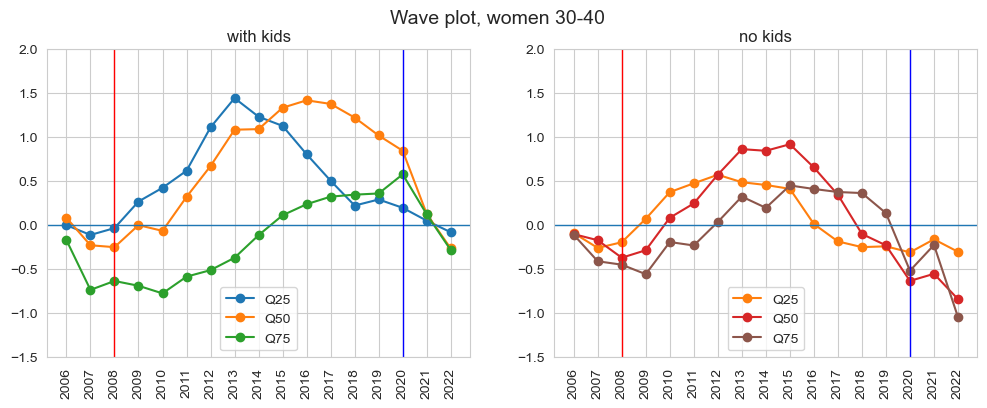

In [11]:
T = len(time_periods_thin)
time_periods_thin_labels= time_periods_thin
time_dict = dict(zip(time_periods_thin, np.arange(0,T*2,2)))
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.suptitle('Wave plot, women 30-40',fontsize=14)
plt.subplot(121)
plt.title('with kids')
for j,q in enumerate([25,50,75]):
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='Q{}'.format(q),color=colors[j])
    
plt.axhline(0,lw=1)
plt.ylim(-1.5,2)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(time_dict["2008"],c='r',lw=1)
plt.axvline(time_dict["2020"],c='b',lw=1)

plt.subplot(122)
plt.title('no kids')
plt.ylim(-1.5,2)
for j,q in enumerate([25,50,75]):
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k[q],marker='o', label='Q{}'.format(q),color=colors[(j*2)+1])
plt.axhline(0,lw=1)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(time_dict["2008"],c='r',lw=1)
plt.axvline(time_dict["2020"],c='b',lw=1)

#plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_women_kids_yy.pdf',format='pdf',bbox_inches='tight')
plt.show()

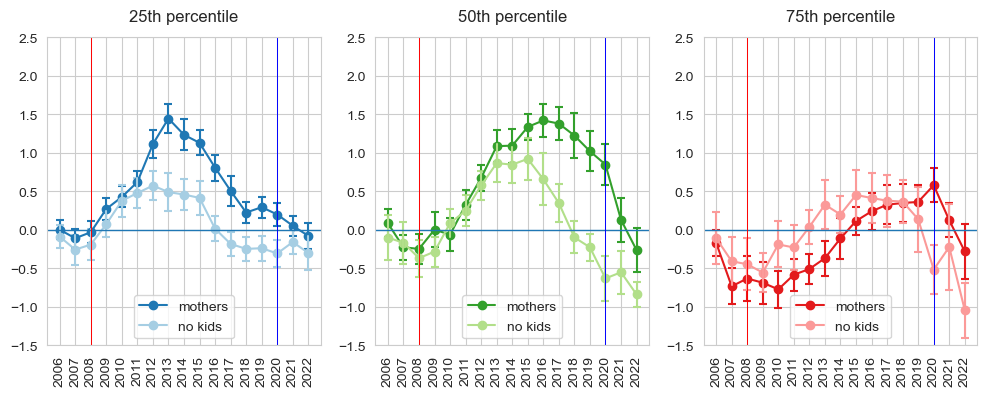

In [12]:
T = len(time_periods_thin)
time_dict = dict(zip(time_periods_thin, np.arange(0,T*2,2)))
time_periods_thin_labels= time_periods_thin

plt.figure(figsize=(12,4))
# plt.suptitle('Time dummies in quantile regressions, women 30-35, Spain',fontsize=14)
with sn.color_palette('Paired',6):
    colors = sn.color_palette()
    for j,q in enumerate([25,50,75]):
        plt.subplot(131+j)
        plt.title("{}th percentile".format(q), fontsize=12, y=1.025)
        plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='mothers'.format(q),color=colors[(j*2)+1])
        plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[(j*2)+1])
        plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[(j*2)+1])
        plt.plot(np.arange(0,T*2,2),coeffs_period_0k[q],marker='o', label='no kids'.format(q),color=colors[(j*2)])
        plt.scatter(np.arange(0,T*2,2),lower_95_period_0k[q],marker='_',color=colors[(j*2)])
        plt.scatter(np.arange(0,T*2,2),upper_95_period_0k[q],marker='_',color=colors[(j*2)])
        for i in range(T):
            plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[(j*2)+1])
            plt.plot((i*2,i*2),(lower_95_period_0k[q][i],upper_95_period_0k[q][i]),c=colors[(j*2)])
        plt.axhline(0,lw=1)
        plt.ylim(-1.5,2.5)
        plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
        plt.legend()
        plt.axvline(time_dict["2008"],c='r',lw=0.7)
        plt.axvline(time_dict["2020"],c='b',lw=0.7)

plt.savefig('./plots_tenure/qregs_spa_3040_time_dummies_women_both_yy.pdf',format='pdf',bbox_inches='tight')
plt.show()

<a id='urgh_3035'></a>


## Quantile regressions for tenure: coefficients by year

### Men 30-35

Jump to

 - [Women 30-35](#index)
 
 
 - [Employment regresssions](#employment)

 --------------
 Split result tables

In [13]:
path = './results/'
name = 'sqtreg_fathers_3040_hemp_yy_agefix'

file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)
tab_dads_45_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)
tab_dads_45_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)

file_split('{}_0k.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25_0k = read_table(path+'{}_0k_1.log'.format(name),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)
tab_dads_45_50_0k = read_table(path+'{}_0k_2.log'.format(name),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)
tab_dads_45_75_0k = read_table(path+'{}_0k_3.log'.format(name),
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','yd'],index_to_int=False)

In [14]:
coeffs_period_m = {}
lower_95_period_m = {}
upper_95_period_m = {}
all_tabs_m = dict(zip([25,50,75],[tab_dads_45_25,tab_dads_45_50,tab_dads_45_75]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_m[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_m[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_m[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_m[q] = coeffs.copy()
    lower_95_period_m[q] = lower.copy()
    upper_95_period_m[q] = upper.copy()


In [15]:
coeffs_period_m_0k = {}
lower_95_period_m_0k = {}
upper_95_period_m_0k = {}
all_tabs_m_0k = dict(zip([25,50,75],[tab_dads_45_25_0k,tab_dads_45_50_0k,tab_dads_45_75_0k]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_m_0k[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_m_0k[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_m_0k[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_m_0k[q] = coeffs.copy()
    lower_95_period_m_0k[q] = lower.copy()
    upper_95_period_m_0k[q] = upper.copy()


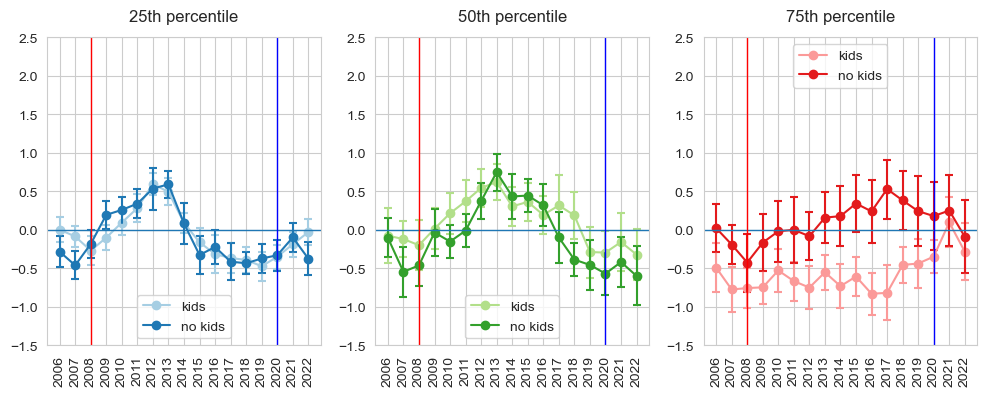

In [16]:
T = len(time_periods_thin)

plt.figure(figsize=(12,4))
# plt.suptitle('Time dummies in quantile regressions, men 30-35, Spain',fontsize=14)
with sn.color_palette('Paired',6):
    colors = sn.color_palette()
    for j,q in enumerate([25,50,75]):
        plt.subplot(131+j)
        plt.title("{}th percentile".format(q), fontsize=12, y=1.025)
        plt.plot(np.arange(0,T*2,2),coeffs_period_m[q],marker='o', label='kids'.format(q),color=colors[(j*2)])
        plt.scatter(np.arange(0,T*2,2),lower_95_period_m[q],marker='_',color=colors[(j*2)])
        plt.scatter(np.arange(0,T*2,2),upper_95_period_m[q],marker='_',color=colors[(j*2)])
        plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k[q],marker='o', label='no kids'.format(q),color=colors[(j*2)+1])
        plt.scatter(np.arange(0,T*2,2),lower_95_period_m_0k[q],marker='_',color=colors[(j*2)+1])
        plt.scatter(np.arange(0,T*2,2),upper_95_period_m_0k[q],marker='_',color=colors[(j*2)+1])
        for i in range(T):
            plt.plot((i*2,i*2),(lower_95_period_m[q][i],upper_95_period_m[q][i]),c=colors[(j*2)])
            plt.plot((i*2,i*2),(lower_95_period_m_0k[q][i],upper_95_period_m_0k[q][i]),c=colors[(j*2)+1])
        plt.axhline(0,lw=1)
        plt.ylim(-1.5,2.5)
        plt.xticks(np.arange(0,T*2,2),time_periods_thin,rotation=90)
        plt.legend()
        plt.axvline(time_dict["2008"],c='r',lw=1)
        plt.axvline(time_dict["2020"],c='b',lw=1)

#plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_men_both_yy.pdf',format='pdf',bbox_inches='tight')
plt.show()

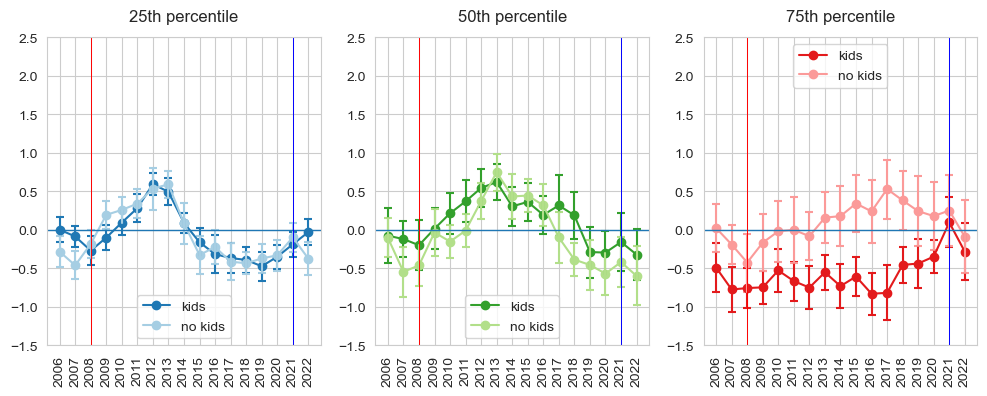

In [17]:
T = len(time_periods_thin)

plt.figure(figsize=(12,4))
# plt.suptitle('Time dummies in quantile regressions, men 30-35, Spain',fontsize=14)
with sn.color_palette('Paired',6):
    colors = sn.color_palette()
    for j,q in enumerate([25,50,75]):
        plt.subplot(131+j)
        plt.title("{}th percentile".format(q), fontsize=12, y=1.025)
        plt.plot(np.arange(0,T*2,2),coeffs_period_m[q],marker='o', label='kids'.format(q),color=colors[(j*2)+1])
        plt.scatter(np.arange(0,T*2,2),lower_95_period_m[q],marker='_',color=colors[(j*2)+1])
        plt.scatter(np.arange(0,T*2,2),upper_95_period_m[q],marker='_',color=colors[(j*2)+1])
        plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k[q],marker='o', label='no kids'.format(q),color=colors[(j*2)])
        plt.scatter(np.arange(0,T*2,2),lower_95_period_m_0k[q],marker='_',color=colors[(j*2)])
        plt.scatter(np.arange(0,T*2,2),upper_95_period_m_0k[q],marker='_',color=colors[(j*2)])
        for i in range(T):
            plt.plot((i*2,i*2),(lower_95_period_m[q][i],upper_95_period_m[q][i]),c=colors[(j*2)+1])
            plt.plot((i*2,i*2),(lower_95_period_m_0k[q][i],upper_95_period_m_0k[q][i]),c=colors[(j*2)])
        plt.axhline(0,lw=1)
        plt.ylim(-1.5,2.5)
        plt.xticks(np.arange(0,T*2,2),time_periods_thin,rotation=90)
        plt.legend()
        plt.axvline(4,c='r',lw=0.7)
        plt.axvline(T*2-4,c='b',lw=0.7)

plt.savefig('./plots_tenure/qregs_spa_3040_time_dummies_men_both_yy.pdf',format='pdf',bbox_inches='tight')
plt.show()

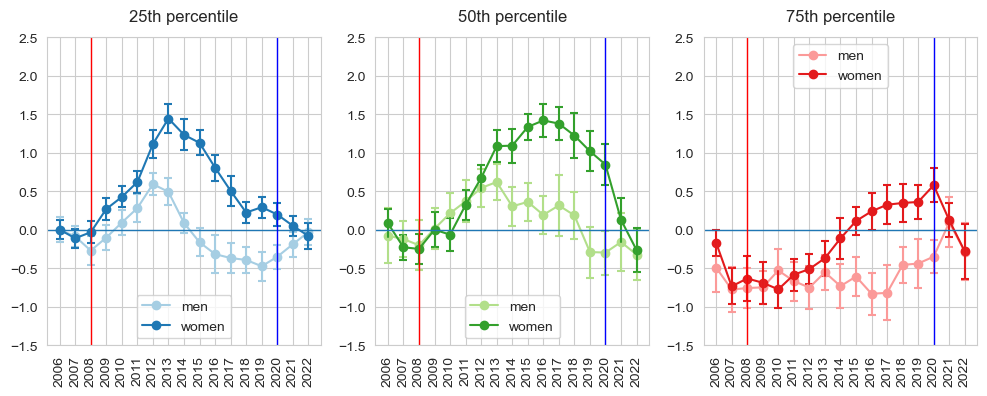

In [18]:
T = len(time_periods_thin)

plt.figure(figsize=(12,4))
# plt.suptitle('Time dummies in quantile regressions, men 30-35, Spain',fontsize=14)
with sn.color_palette('Paired',6):
    colors = sn.color_palette()
    for j,q in enumerate([25,50,75]):
        plt.subplot(131+j)
        plt.title("{}th percentile".format(q), fontsize=12, y=1.025)
        plt.plot(np.arange(0,T*2,2),coeffs_period_m[q],marker='o', label='men'.format(q),color=colors[(j*2)])
        plt.scatter(np.arange(0,T*2,2),lower_95_period_m[q],marker='_',color=colors[(j*2)])
        plt.scatter(np.arange(0,T*2,2),upper_95_period_m[q],marker='_',color=colors[(j*2)])
        plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='women'.format(q),color=colors[(j*2)+1])
        plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[(j*2)+1])
        plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[(j*2)+1])
        for i in range(T):
            plt.plot((i*2,i*2),(lower_95_period_m[q][i],upper_95_period_m[q][i]),c=colors[(j*2)])
            plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[(j*2)+1])
        plt.axhline(0,lw=1)
        plt.ylim(-1.5,2.5)
        plt.xticks(np.arange(0,T*2,2),time_periods_thin,rotation=90)
        plt.legend()
        plt.axvline(time_dict["2008"],c='r',lw=1)
        plt.axvline(time_dict["2020"],c='b',lw=1)

plt.savefig('./plots_tenure/qregs_spa_3040_time_dummies_kids_yy.pdf',format='pdf',bbox_inches='tight')
plt.show()

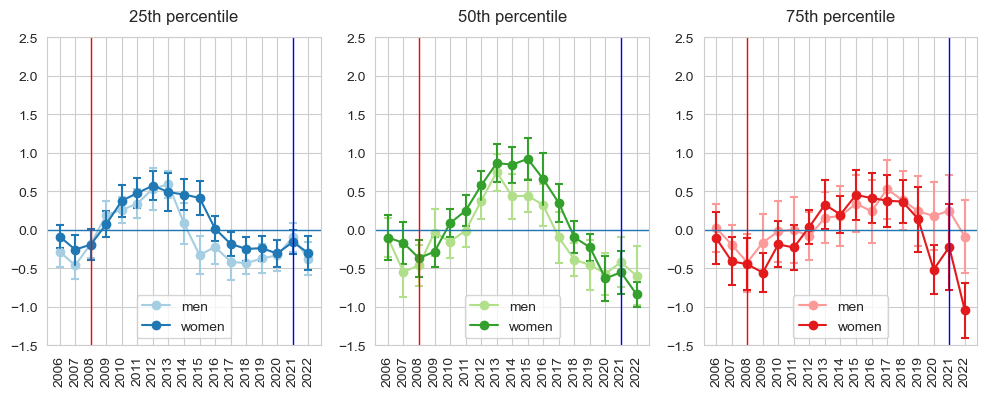

In [22]:
T = len(time_periods_thin)

plt.figure(figsize=(12,4))
# plt.suptitle('Time dummies in quantile regressions, men 30-35, Spain',fontsize=14)
with sn.color_palette('Paired',6):
    colors = sn.color_palette()
    for j,q in enumerate([25,50,75]):
        plt.subplot(131+j)
        plt.title("{}th percentile".format(q), fontsize=12, y=1.025)
        plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k[q],marker='o', label='men'.format(q),color=colors[(j*2)])
        plt.scatter(np.arange(0,T*2,2),lower_95_period_m_0k[q],marker='_',color=colors[(j*2)])
        plt.scatter(np.arange(0,T*2,2),upper_95_period_m_0k[q],marker='_',color=colors[(j*2)])
        plt.plot(np.arange(0,T*2,2),coeffs_period_0k[q],marker='o', label='women'.format(q),color=colors[(j*2)+1])
        plt.scatter(np.arange(0,T*2,2),lower_95_period_0k[q],marker='_',color=colors[(j*2)+1])
        plt.scatter(np.arange(0,T*2,2),upper_95_period_0k[q],marker='_',color=colors[(j*2)+1])
        for i in range(T):
            plt.plot((i*2,i*2),(lower_95_period_m_0k[q][i],upper_95_period_m_0k[q][i]),c=colors[(j*2)])
            plt.plot((i*2,i*2),(lower_95_period_0k[q][i],upper_95_period_0k[q][i]),c=colors[(j*2)+1])
        plt.axhline(0,lw=1)
        plt.ylim(-1.5,2.5)
        plt.xticks(np.arange(0,T*2,2),time_periods_thin,rotation=90)
        plt.legend()
        plt.axvline(4,c='r',lw=1)
        plt.axvline(T*2-4,c='b',lw=1)

plt.savefig('./plots_tenure/qregs_spa_3040_time_dummies_Nokids_yy.pdf',format='pdf',bbox_inches='tight')
plt.show()